- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [1]:
import sys
print(sys.executable)

c:\Users\mayeu\.venvs\venvPFE\Scripts\python.exe


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cpu
None
False


In [3]:
import numpy as np
import pandas as pd
import scipy.ndimage

## Generate datas

First we need to generate the data by simplifying the era5 grid with the corresponding keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For all key, we will generate data based on the density of these 5 pressure levels ([0, 10, 20, 30, 36]).

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy

In [5]:
from import_era5 import data_generation

input_variables =['geopotential', 
                    'specific_humidity','temperature',
                    'u_component_of_wind',
                    'v_component_of_wind',
                    'specific_cloud_ice_water_content',
                    'specific_cloud_liquid_water_content']

forcing_variables = ['sea_ice_cover', 'sea_surface_temperature']

longitude_nodes=32
latitude_nodes=16
level = [0, 10, 20, 30, 36]

path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

regridded, sliced_era5 = data_generation(path = path,
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level)

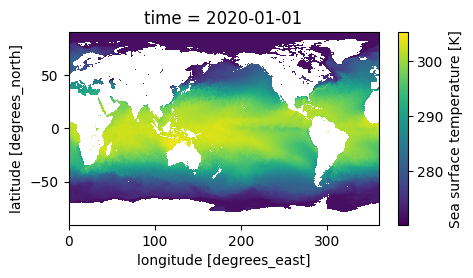

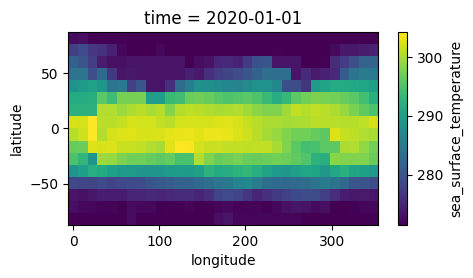

In [6]:
sliced_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [7]:
regridded

<xarray.Dataset> Size: 76kB
Dimensions:                              (level: 5, longitude: 32, latitude: 16)
Coordinates:
  * level                                (level) int64 40B 1 100 450 850 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 256B 0.0 ... 348.8
  * latitude                             (latitude) float64 128B -81.65 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 10kB ...
    specific_humidity                    (level, longitude, latitude) float32 10kB ...
    temperature                          (level, longitude, latitude) float32 10kB ...
    u_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    v_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 10kB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 10kB ...
    sea_ice_cover                        (longitude, latitude) float32 2kB 0....
    sea_surface_temperature              (longitude, latitude) float32 2kB 27...

### Normalization of input features

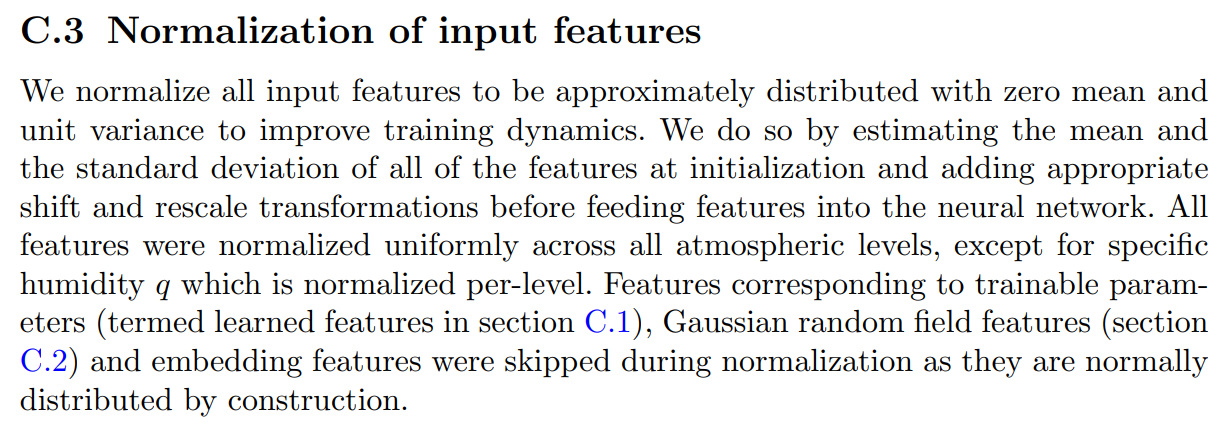

First of all, we normalise the data in order to obtain reduced centred data. And we do so for all the other features. The normalised data is then transferred to encoder (Lounis)

In [8]:
regridded

<xarray.Dataset> Size: 76kB
Dimensions:                              (level: 5, longitude: 32, latitude: 16)
Coordinates:
  * level                                (level) int64 40B 1 100 450 850 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 256B 0.0 ... 348.8
  * latitude                             (latitude) float64 128B -81.65 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 10kB ...
    specific_humidity                    (level, longitude, latitude) float32 10kB ...
    temperature                          (level, longitude, latitude) float32 10kB ...
    u_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    v_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 10kB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 10kB ...
    sea_ice_cover                        (longitude, latitude) float32 2kB 0....
    sea_surface_temperature              (longitude, latitude) float32 2kB 27...

In [9]:
def normalize_z_score(array):
    mean_val = array.mean(dim=array.dims)
    std_val = array.std(dim=array.dims)
    return (array - mean_val) / std_val

normalized_dataset = regridded.copy()

for var in regridded.data_vars:
    dims = regridded[var].dims
    normalized_dataset[var] = normalize_z_score(regridded[var])

normalized_dataset

<xarray.Dataset> Size: 76kB
Dimensions:                              (level: 5, longitude: 32, latitude: 16)
Coordinates:
  * level                                (level) int64 40B 1 100 450 850 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 256B 0.0 ... 348.8
  * latitude                             (latitude) float64 128B -81.65 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 10kB ...
    specific_humidity                    (level, longitude, latitude) float32 10kB ...
    temperature                          (level, longitude, latitude) float32 10kB ...
    u_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    v_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 10kB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 10kB ...
    sea_ice_cover                        (longitude, latitude) float32 2kB 1....
    sea_surface_temperature              (longitude, latitude) float32 2kB -1...

## Encoder

### Lounis part

## Learn Physic part

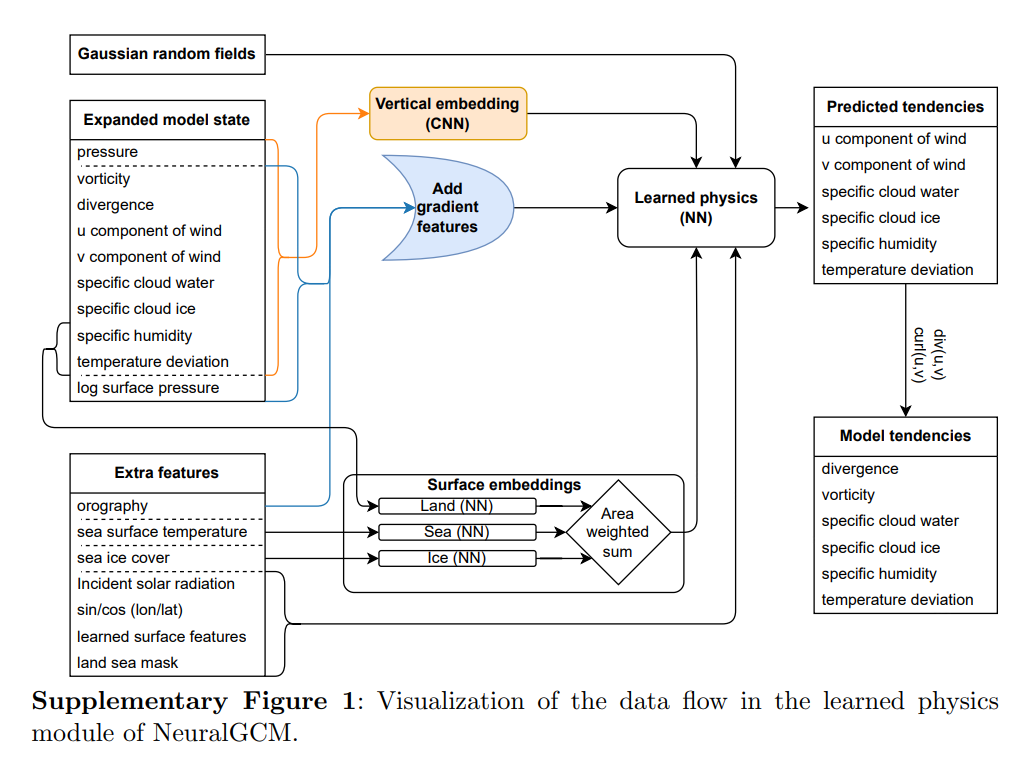

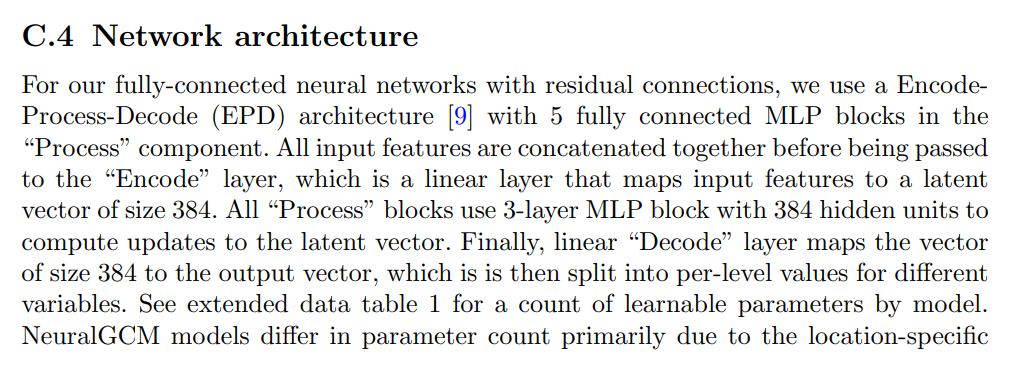

### Vertical embedding network

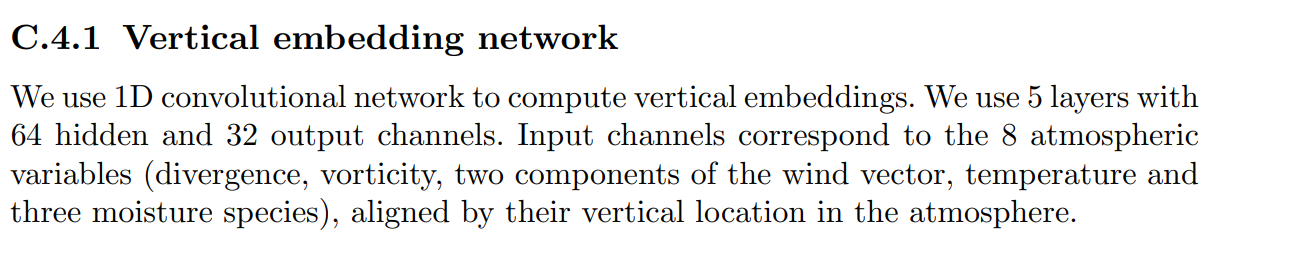

In [10]:
input_channels = 8
hidden_channels = 64
output_channels = 32
num_layers = 5
vertical_dim = 5

x = torch.rand(16, input_channels, vertical_dim)
x.shape

torch.Size([16, 8, 5])

For the learned physics module, we gonna first generate random data.

In [11]:
vorticity = torch.empty((5, 32, 16))
divergence = torch.empty((5, 32, 16))
u_component_of_wind = torch.empty((5, 32, 16))
v_component_of_wind = torch.empty((5, 32, 16))
specific_cloud_water = torch.empty((5, 32, 16))
specific_cloud_ice = torch.empty((5, 32, 16))
specific_humidity = torch.empty((5, 32, 16))
temperature_deviation = torch.empty((5, 32, 16))

def generate_data(shape):
    data = torch.normal(mean=0, std=1, size=shape).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    return torch.tensor(data)

for i in range(5):
    vorticity[i] = generate_data((32, 16))
    divergence[i] = generate_data((32, 16))
    u_component_of_wind[i] = generate_data((32, 16))
    v_component_of_wind[i] = generate_data((32, 16))
    specific_cloud_water[i] = generate_data((32, 16))
    specific_cloud_ice[i] = generate_data((32, 16))
    specific_humidity[i] = generate_data((32, 16))
    temperature_deviation[i] = generate_data((32, 16))

features = torch.stack([ 
    vorticity, 
    divergence, 
    u_component_of_wind, 
    v_component_of_wind, 
    specific_cloud_water, 
    specific_cloud_ice, 
    specific_humidity, 
    temperature_deviation
])

data = features.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
data = data.reshape(-1, 8, 5)  # (batch_size=32*16, input_channels=8, sequence_length=5)

print("Shape of features tensor:", data.shape)


Shape of features tensor: torch.Size([512, 8, 5])


In [12]:
import torch.nn as nn

class VerticalEmbeddingNetwork(nn.Module):
    def __init__(self):
        super(VerticalEmbeddingNetwork, self).__init__()
        
        #we code the convolution network describe in the paper
        self.net = nn.Sequential(
            nn.Conv1d(in_channels = 8, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            )
        
    def forward(self, x) :
        x = self.net(x)
        return x

model_VEN = VerticalEmbeddingNetwork()
output_VEN = model_VEN(data)
output_VEN.shape

torch.Size([512, 32, 5])

### Surface embedding network

In [13]:
sea_ice_cover = torch.empty((5, 32, 16))
sea_surface_temperature = torch.empty((5, 32, 16))

for i in range(5):
    sea_ice_cover[i] = generate_data((32, 16))
    sea_surface_temperature[i] = generate_data((32, 16))

data = features.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
data = data.reshape(-1, 8, 5)  # (batch_size=32*16, input_channels=8, sequence_length=5)

print("Shape of features tensor:", data.shape)


Shape of features tensor: torch.Size([512, 8, 5])


In [28]:
class SurfaceEmbeddingNetwork(nn.Module):
    def __init__(self, surface_type):
        super(SurfaceEmbeddingNetwork, self).__init__()
        self.surface_type = surface_type
        
        
        if self.surface_type == 'sea' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 1, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )
        
        elif self.surface_type == 'land' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 2, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )   
            
        elif self.surface_type == 'ice' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 2, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )
        
    def forward(self, x) :
        x = self.net(x)
        return x

In [30]:
class AreaWeightedSum(nn.Module):
    def __init__(self):
        super(AreaWeightedSum, self).__init__()
    
    def forward(self, sea_embedding, land_embedding, ice_embedding, sea_fraction, land_fraction, ice_fraction):
        return sea_embedding * sea_fraction + land_embedding * land_fraction + ice_embedding * ice_fraction


In [31]:
sea_input = torch.randn(10, 1)  # 10 échantillons, 1 variable (SST)
land_input = torch.randn(10, 2)  # 10 échantillons, 2 variables (température, humidité)
ice_input = torch.randn(10, 2)  # 10 échantillons, 2 variables (température, humidité)

sea_net = SurfaceEmbeddingNetwork(surface_type='sea')
land_net = SurfaceEmbeddingNetwork(surface_type='land')
ice_net = SurfaceEmbeddingNetwork(surface_type='ice')

sea_embedding = sea_net(sea_input)
land_embedding = land_net(land_input)
ice_embedding = ice_net(ice_input)

print(sea_embedding.shape)
print(land_embedding.shape)
print(ice_embedding.shape)

land_fraction = torch.randn(10, 1)  # Fraction de terre à chaque point de la grille
sea_fraction = torch.randn(10, 1)   # Fraction de mer à chaque point de la grille
ice_fraction = torch.randn(10, 1)   # Fraction de glace de mer à chaque point de la grille

# Calcul de la somme pondérée par la surface
area_weighted_sum = AreaWeightedSum()
final_embedding = area_weighted_sum(land_embedding, sea_embedding, ice_embedding, land_fraction, sea_fraction, ice_fraction)

print("Final Area Weighted Sum:", final_embedding.shape)

torch.Size([10, 8])
torch.Size([10, 8])
torch.Size([10, 8])
Final Area Weighted Sum: torch.Size([10, 8])


In [33]:
import torch
import torch.nn as nn

class EPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, hidden_units=384):
        super(EPDNetwork, self).__init__()

        # Encode : Couche linéaire pour encoder les entrées combinées
        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)

        # Process : Bloc MLP pour traiter le vecteur latent
        self.process_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_size, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, latent_size)
            )
            for _ in range(num_process_blocks)
        ])

        # Decode : Couche linéaire pour décoder le vecteur latent en sortie
        self.decode = nn.Linear(latent_size, 3)  # Par exemple, 3 variables à prédire (vent, température, humidité)

    def forward(self, vertical_embedding, surface_embedding):
        # Concaténer les embeddings verticaux et de surface
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        # Encoder : projeté vers l'espace latent
        x = self.encode(x)
        
        # Process : passer à travers les blocs MLP avec connexions résiduelles
        for block in self.process_blocks:
            x_residual = x  # Connexion résiduelle
            x = block(x)
            x += x_residual  # Ajouter la connexion résiduelle

        # Decoder : décoder le vecteur latent en la sortie
        output = self.decode(x)
        return output

# Exemple d'utilisation :
vertical_embedding_size = 32  # Taille de l'output du VerticalEmbedding
surface_embedding_size = 8    # Taille de l'output du SurfaceEmbedding

# Créer le modèle
model_epd = EPDNetwork(vertical_embedding_size, surface_embedding_size)

# Exemple d'entrées (embeddings simulés)
vertical_embedding = torch.randn(1, vertical_embedding_size)  # Exemple de batch de taille 1
surface_embedding = torch.randn(1, surface_embedding_size)

# Prédiction des tendances physiques (vent, température, humidité)
predicted_tendencies = model_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies)


tensor([[-0.6804, -0.1314, -0.2852]], grad_fn=<AddmmBackward0>)


In [34]:
import torch
import torch.nn as nn
from torch.nn import Transformer

class TransformerEPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, num_heads=8, num_encoder_layers=6, hidden_units=384):
        super(TransformerEPDNetwork, self).__init__()

        # Encode : Couche linéaire pour encoder les entrées combinées
        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)

        # Transformer Encoder
        self.transformer = Transformer(d_model=latent_size, nhead=num_heads, num_encoder_layers=num_encoder_layers, dim_feedforward=hidden_units)

        # Decode : Couche linéaire pour décoder le vecteur latent en sortie
        self.decode = nn.Linear(latent_size, 3)  # Par exemple, 3 variables à prédire (vent, température, humidité)

    def forward(self, vertical_embedding, surface_embedding):
        # Concaténer les embeddings verticaux et de surface
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        # Encoder : projeté vers l'espace latent
        x = self.encode(x)

        # Transformer : Appliquer le Transformer Encoder
        # Transformer attend une entrée de forme (seq_len, batch_size, features)
        # Ici, la séquence est de taille 1 et nous avons un batch_size de N (toutes les données en même temps)
        x = x.unsqueeze(0)  # Ajouter la dimension de séquence (seq_len=1)
        x = self.transformer(x, x)  # Appliquer l'attention Transformer
        
        # Après le transformer, nous avons un vecteur de sortie de dimension latent_size
        # Nous récupérons la sortie du premier élément de la séquence
        x = x.squeeze(0)  # Retirer la dimension de séquence

        # Decoder : décoder le vecteur latent en la sortie
        output = self.decode(x)
        return output

vertical_embedding_size = 32  # Taille de l'output du VerticalEmbedding
surface_embedding_size = 8    # Taille de l'output du SurfaceEmbedding

model_transformer_epd = TransformerEPDNetwork(vertical_embedding_size, surface_embedding_size)

vertical_embedding = torch.randn(1, vertical_embedding_size)  # Exemple de batch de taille 1
surface_embedding = torch.randn(1, surface_embedding_size)

predicted_tendencies = model_transformer_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies)


c:\Users\mayeu\.venvs\venvPFE\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([[-0.1193, -0.2190, -0.1763]], grad_fn=<AddmmBackward0>)


### Network output scaling